In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd

import copy

In [4]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.9/162.9 kB 3.2 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.12/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


  Cloning https://github.com/vanbreugel-lab/pybounds to /tmp/pip-req-build-1shkmejx
  Running command git clone --filter=blob:none --quiet https://github.com/vanbreugel-lab/pybounds /tmp/pip-req-build-1shkmejx
  Resolved https://github.com/vanbreugel-lab/pybounds to commit 96f12039ac9e1e3ef4381cd09a026f6bbf70ad5c
  Preparing metadata (setup.py) ... done
  Created wheel for pybounds: filename=pybounds-0.0.13-py3-none-any.whl size=19546 sha256=c2ed4a024e4d1f8337f817e6f9dd02eee48e4b8e8fe01af47f64c9268d5e2087
  Stored in directory: /tmp/pip-ephem-wheel-cache-jflxa9tg/wheels/cb/f8/fb/ff1887f9a2f35c3edad7b1acb7da69437c1fd8d885a800578d
Successfully built pybounds


### Import plotting utilities and planar drone locally or from github

In [5]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
extended_kalman_filter = import_local_or_github('extended_kalman_filter', directory='../Utility')

Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>


# Planar drone dynamics

Now all the drone dynamics are in the helper file, `planar_drone.py`

$
\mathbf{\dot{x}} = \mathbf{f}(\mathbf{x},\mathbf{u}) =
\frac{d}{dt}
\begin{bmatrix}
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
\bbox[yellow]{x} \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
\bbox[pink]{k}
\end{bmatrix} =
\overset{f_0}{\begin{bmatrix}
\bbox[yellow]{\dot{\theta}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
-\bbox[lightblue]{g} \\[0.3em]
0
\end{bmatrix}} +
\overset{f_1}{\begin{bmatrix}
0 \\[0.3em]
\bbox[lightblue]{l}\bbox[pink]{k}/\bbox[lightblue]{I_{yy}} \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{j_1} +
\overset{f_2}{\begin{bmatrix}
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
-\bbox[pink]{k}\bbox[yellow]{\sin\theta}/\bbox[lightblue]{m} \\[0.3em]
0 \\[0.3em]
\bbox[pink]{k}\bbox[yellow]{\cos\theta}/\bbox[lightblue]{m}  \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{j_2}
$

We begin assuming that we have the following measurements, which could come from a camera (ventral optic flow) and IMU. The acceleration measurements must be defined by the dynamics equations.

$
\mathbf{y} = \mathbf{{h}}(\mathbf{{x}}, \mathbf{{u}}) =
\begin{bmatrix}
\bbox[yellow]{\dot{x}/z} \\[0.3em]
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
\bbox[red]{\ddot{x}} \\[0.3em]
\bbox[red]{\ddot{z}} \\[0.3em]
\end{bmatrix} =
\begin{bmatrix}
\bbox[yellow]{\dot{x}/z} \\[0.3em]
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
0 \\[0.3em]
-\bbox[lightblue]{g} \\[0.3em]
\end{bmatrix} +
\begin{bmatrix}
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
-\bbox[pink]{k}\bbox[yellow]{\sin\theta}/\bbox[lightblue]{m} \\[0.3em]
\bbox[pink]{k}\bbox[yellow]{\cos\theta}/\bbox[lightblue]{m} \\[0.3em]
\end{bmatrix} \bbox[lightgreen]{j_2}
$

# Dynamics and measurement functions

In [6]:
f = planar_drone.F().f
h = planar_drone.H('h_camera_imu').h

In [7]:
print('states:')
print(f(None, None, return_state_names=True))
print()
print('measurements:')
print(h(None, None, return_measurement_names=True))

states:
['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot', 'k']

measurements:
['optic_flow', 'theta', 'theta_dot', 'accel_x', 'accel_z']


# Run MPC simulation

Notice the small dt here -- 0.02 instead of our usual 0.1!

In [9]:
t_sim, x_sim, u_sim, y_sim, simulator = planar_drone.simulate_drone(f, h=h, dt=0.02, tsim_length=20, trajectory_shape='squiggle')

### Plot the x, z trajectory

Text(0, 0.5, 'z pos')

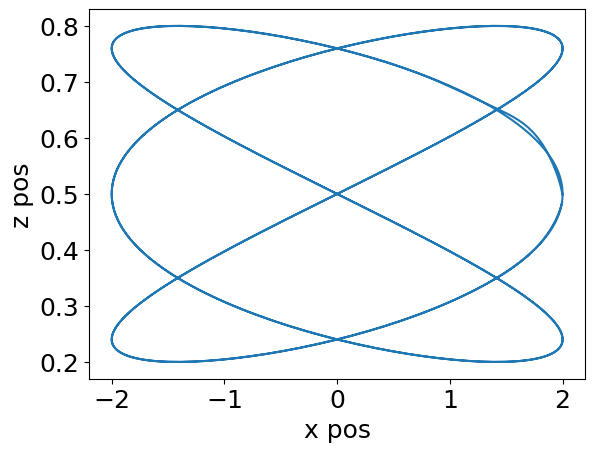

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_sim['x'], x_sim['z'])

ax.set_xlabel('x pos')
ax.set_ylabel('z pos')

# Simulate noisy measurements

Choose noise properties for each sensor, and apply the noise to each measurement stream.

Notice the low noise levels here!

In [11]:
measurement_noise_stds = {'optic_flow': 0.2,
                          'theta': 0.1,
                          'theta_dot': 0.1,
                          'accel_x': 0.1,
                          'accel_z': 0.1,
                         }

In [12]:
y_noisy = {key: y_sim[key] + np.random.normal(0, measurement_noise_stds[key], len(y_sim[key])) for key in y_sim.keys()}

<Axes: xlabel='Time', ylabel='optic_flow'>

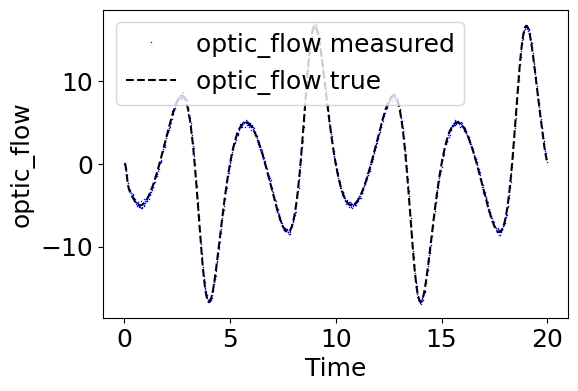

In [13]:
plot_tme(t_sim, y_sim['optic_flow'], y_noisy['optic_flow'], label_var='optic_flow')

<Axes: xlabel='Time', ylabel='accel_x'>

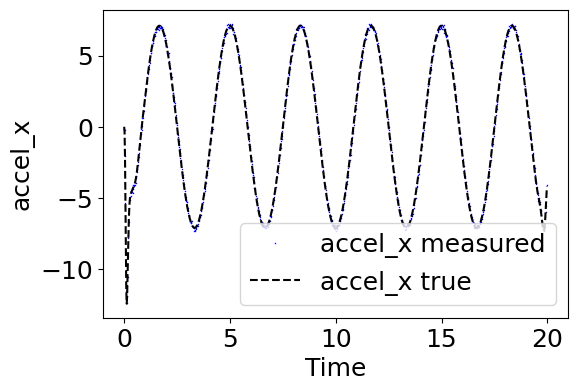

In [14]:
plot_tme(t_sim, y_sim['accel_x'], y_noisy['accel_x'], label_var='accel_x')

### Save data as dataframes

In [15]:
y_noisy_df = pd.DataFrame(y_noisy)
u_sim_df = pd.DataFrame(u_sim)
x_sim_df = pd.DataFrame(x_sim)

# Kalman filter parameters and initilization

In [16]:
# initial state guess
x0 = np.ones(7)*2

# initial controls
u0 = np.zeros(2)

# initial error covariance guess -- choose the identity, sometimes 10x or 100x may work better
P0 = np.eye(7)*1

In [17]:
# measurement covariance matrix, defined by the variances of the measurements themselves
R = np.diag( list(measurement_noise_stds.values()) )**2

# process covariance matrix, somewhat open ended choice, it smaller values will lead to smoother responses and slower convergence
Q = np.diag([1e-4]*len(x0))

In [18]:
# extract the time step from t_sim
dt = np.mean(np.diff(t_sim))

# Extended Kalman Filter

In [19]:
EKF = extended_kalman_filter.EKF(f, h, x0, u0, P0, Q, R,
                                 dynamics_type='continuous', # this EKF will discretize the continuous dynamics at each step
                                 discretization_timestep=dt, # time step for discretization
                                 circular_measurements=(1,0,0,0,0,0,0)) # indicate any circular variables for improved performance

In [20]:
EKF.estimate(y_noisy_df, u_sim_df) # optional arguments include time varying dt, R, Q

In [21]:
# the EKF saves many features
EKF.history.keys()

dict_keys(['X', 'U', 'Z', 'P', 'P_diags', 'R', 'Q', 'F', 'H', 'S', 'K', 'E', 'rho', 'Jk', 'inv_Jk'])

In [22]:
# Package the state estimate nicely
x_est = pd.DataFrame(np.vstack(EKF.history['X']), columns=f(None,None,return_state_names=True))

In [23]:
# Package the error coviarance diagonals nicely
P_diags = np.vstack([EKF.history['P_diags'][i] for i in range(len(EKF.history['P_diags']))])
P_diags = pd.DataFrame(P_diags, columns=f(None,None,return_state_names=True))

### Plot EKF results and 3*sigma bounds

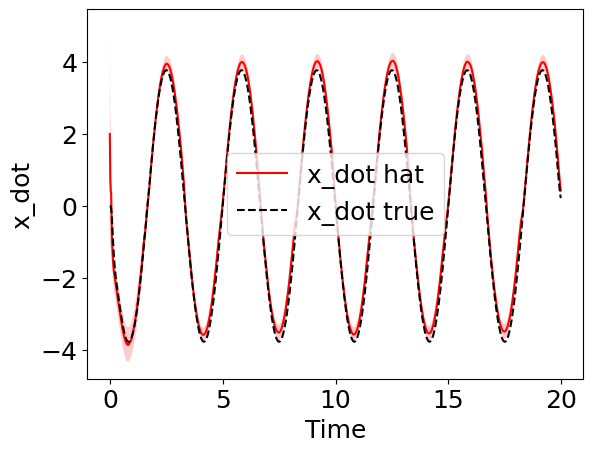

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'x_dot'

plot_tme(t_sim, x_sim[state], None, x_est[state], label_var=state, ax=ax)

plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

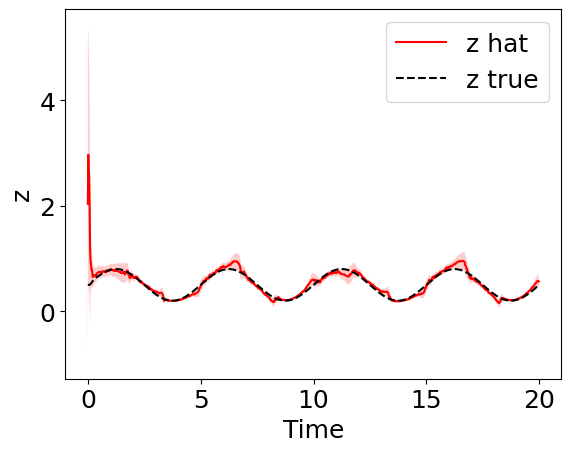

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'z'

plot_tme(t_sim, x_sim[state], None, x_est[state], label_var=state, ax=ax)

plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])

ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

# Exercises

1. Try with a different trajectory -- one that is constant velocity sometimes. You can get that trajectory by using this code:
```
t_sim, x_sim, u_sim, y_sim, simulator = planar_drone.simulate_drone(f, h=h, dt=0.02, tsim_length=20, trajectory_shape='alternating')
```
2. Go back to the original trajectory ('squiggle') Increase the noise level (e.g. double the noise). How does the filter do?
3. Decrease the time step to 0.1, how does the filter do?
4. Try a different measurement function, like:

$
\mathbf{y} = \mathbf{{h}}(\mathbf{{x}}, \mathbf{{u}}) =
\begin{bmatrix}
\bbox[yellow]{\dot{x}/z} \\[0.3em]
\bbox[yellow]{\theta} \\[0.3em]
\bbox[pink]{k} \\[0.3em]
\end{bmatrix}
$

Note, this measurement function is written as `planar_drone.H('h_camera_theta_k').h`

5. How do the results from exercises 1-4 compare to the predictions from the observability analysis?
6. What fundamental difference is there between the function $\mathbf{h}$ from exercise 4, and the original one used?
